# MIMIC-III Dataset Preprocessing

This notebook focuses on preprocessing the MIMIC-III dataset for the HealthAI Suite project. MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over 40,000 patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('ggplot')
sns.set(style="whitegrid")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## 1. Loading the MIMIC-III Dataset Files

First, we'll load the key tables from the MIMIC-III dataset. We'll focus on the most important tables for our analysis.

In [2]:
# Define the path to the MIMIC-III dataset
mimic_path = '../MIMIC-3/'

# List all available files
mimic_files = os.listdir(mimic_path)
print(f"Available files in MIMIC-III dataset: {len(mimic_files)}")
print(mimic_files)

Available files in MIMIC-III dataset: 27
['ADMISSIONS.csv', 'CALLOUT.csv', 'CAREGIVERS.csv', 'CHARTEVENTS.csv', 'CPTEVENTS.csv', 'DATETIMEEVENTS.csv', 'DIAGNOSES_ICD.csv', 'DRGCODES.csv', 'D_CPT.csv', 'D_ICD_DIAGNOSES.csv', 'D_ICD_PROCEDURES.csv', 'D_ITEMS.csv', 'D_LABITEMS.csv', 'ICUSTAYS.csv', 'INPUTEVENTS_CV.csv', 'INPUTEVENTS_MV.csv', 'LABEVENTS.csv', 'MICROBIOLOGYEVENTS.csv', 'NOTEEVENTS.csv', 'OUTPUTEVENTS.csv', 'PATIENTS.csv', 'PRESCRIPTIONS.csv', 'PROCEDUREEVENTS_MV.csv', 'PROCEDURES_ICD.csv', 'SERVICES.csv', 'SHA256SUMS.txt', 'TRANSFERS.csv']


In [3]:
# Load key tables
# Note: We're using a sample of rows to speed up initial exploration
# For full analysis, remove the nrows parameter

# Patient information
patients = pd.read_csv(os.path.join(mimic_path, 'PATIENTS.csv'), nrows=10000)

# Admission information
admissions = pd.read_csv(os.path.join(mimic_path, 'ADMISSIONS.csv'), nrows=10000)

# ICU stays
icustays = pd.read_csv(os.path.join(mimic_path, 'ICUSTAYS.csv'), nrows=10000)

# Diagnoses
diagnoses = pd.read_csv(os.path.join(mimic_path, 'DIAGNOSES_ICD.csv'), nrows=10000)
diagnoses_dict = pd.read_csv(os.path.join(mimic_path, 'D_ICD_DIAGNOSES.csv'))

# Procedures
procedures = pd.read_csv(os.path.join(mimic_path, 'PROCEDURES_ICD.csv'), nrows=10000)
procedures_dict = pd.read_csv(os.path.join(mimic_path, 'D_ICD_PROCEDURES.csv'))

# Normalize column names to UPPER case to match later references
patients.columns = patients.columns.str.upper()
admissions.columns = admissions.columns.str.upper()
icustays.columns = icustays.columns.str.upper()
diagnoses.columns = diagnoses.columns.str.upper()
procedures.columns = procedures.columns.str.upper()
procedures_dict.columns = procedures_dict.columns.str.upper()
diagnoses_dict.columns = diagnoses_dict.columns.str.upper()

print('Loaded tables and normalized column names to uppercase')

Loaded tables and normalized column names to uppercase


## 2. Exploring the Data Structure

Let's examine the structure of each key table to understand the data better.

In [4]:
# Function to display basic information about a dataframe
def explore_dataframe(df, name):
    print(f"\n{'='*50}")
    print(f"Table: {name}")
    print(f"{'='*50}")
    print(f"Shape: {df.shape}")
    print("\nColumn Information:")
    print(df.info())
    print("\nSample Data:")
    display(df.head())
    print("\nMissing Values:")
    missing = df.isnull().sum()
    print(missing[missing > 0])
    print("\nSummary Statistics:")
    display(df.describe(include='all').T)
    
# Explore each dataframe
explore_dataframe(patients, 'PATIENTS')
explore_dataframe(admissions, 'ADMISSIONS')
explore_dataframe(icustays, 'ICUSTAYS')
explore_dataframe(diagnoses, 'DIAGNOSES_ICD')
explore_dataframe(diagnoses_dict, 'D_ICD_DIAGNOSES')
explore_dataframe(procedures, 'PROCEDURES_ICD')
explore_dataframe(procedures_dict, 'D_ICD_PROCEDURES')


Table: PATIENTS
Shape: (100, 8)

Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   row_id       100 non-null    int64 
 1   subject_id   100 non-null    int64 
 2   gender       100 non-null    object
 3   dob          100 non-null    object
 4   dod          100 non-null    object
 5   dod_hosp     70 non-null     object
 6   dod_ssn      77 non-null     object
 7   expire_flag  100 non-null    int64 
dtypes: int64(3), object(5)
memory usage: 6.4+ KB
None

Sample Data:


,row_id,subject_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag
0,9467,10006,F,2094-03-05 00:00:00,2165-08-12 00:00:00,2165-08-12 00:00:00,2165-08-12 00:00:00,1
1,9472,10011,F,2090-06-05 00:00:00,2126-08-28 00:00:00,2126-08-28 00:00:00,NaN,1
2,9474,10013,F,2038-09-03 00:00:00,2125-10-07 00:00:00,2125-10-07 00:00:00,2125-10-07 00:00:00,1
3,9478,10017,F,2075-09-21 00:00:00,2152-09-12 00:00:00,NaN,2152-09-12 00:00:00,1
4,9479,10019,M,2114-06-20 00:00:00,2163-05-15 00:00:00,2163-05-15 00:00:00,2163-05-15 00:00:00,1



Missing Values:
dod_hosp    30
dod_ssn     23
dtype: int64

Summary Statistics:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
row_id,100.0,NaN,NaN,NaN,20452.58,10982.043163,9467.0,9526.5,20209.0,31391.25,31872.0
subject_id,100.0,NaN,NaN,NaN,26162.33,16201.834705,10006.0,10068.5,25128.0,42276.5,44228.0
gender,100,2,F,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dob,100,99,2058-04-23 00:00:00,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dod,100,100,2165-08-12 00:00:00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dod_hosp,70,70,2165-08-12 00:00:00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dod_ssn,77,77,2165-08-12 00:00:00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
expire_flag,100.0,NaN,NaN,NaN,1.0,0.0,1.0,1.0,1.0,1.0,1.0



Table: ADMISSIONS
Shape: (129, 19)

Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   row_id                129 non-null    int64 
 1   subject_id            129 non-null    int64 
 2   hadm_id               129 non-null    int64 
 3   admittime             129 non-null    object
 4   dischtime             129 non-null    object
 5   deathtime             40 non-null     object
 6   admission_type        129 non-null    object
 7   admission_location    129 non-null    object
 8   discharge_location    129 non-null    object
 9   insurance             129 non-null    object
 10  language              81 non-null     object
 11  religion              128 non-null    object
 12  marital_status        113 non-null    object
 13  ethnicity             129 non-null    object
 14  edregtime             92 non-null

,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data
0,12258,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,SEPARATED,BLACK/AFRICAN AMERICAN,2164-10-23 16:43:00,2164-10-23 23:00:00,SEPSIS,0,1
1,12263,10011,105331,2126-08-14 22:32:00,2126-08-28 18:59:00,2126-08-28 18:59:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Private,NaN,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,NaN,NaN,HEPATITIS B,1,1
2,12265,10013,165520,2125-10-04 23:36:00,2125-10-07 15:13:00,2125-10-07 15:13:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,NaN,UNKNOWN/NOT SPECIFIED,NaN,NaN,SEPSIS,1,1
3,12269,10017,199207,2149-05-26 17:19:00,2149-06-03 18:42:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,CATHOLIC,DIVORCED,WHITE,2149-05-26 12:08:00,2149-05-26 19:45:00,HUMERAL FRACTURE,0,1
4,12270,10019,177759,2163-05-14 20:43:00,2163-05-15 12:00:00,2163-05-15 12:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,DIVORCED,WHITE,NaN,NaN,ALCOHOLIC HEPATITIS,1,1



Missing Values:
deathtime         89
language          48
religion           1
marital_status    16
edregtime         37
edouttime         37
dtype: int64

Summary Statistics:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
row_id,129.0,NaN,NaN,NaN,28036.44186,14036.548988,12258.0,12339.0,39869.0,40463.0,41092.0
subject_id,129.0,NaN,NaN,NaN,28010.410853,16048.502883,10006.0,10088.0,40310.0,42135.0,44228.0
hadm_id,129.0,NaN,NaN,NaN,152343.44186,27858.788248,100375.0,128293.0,157235.0,174739.0,199395.0
admittime,129,129,2164-10-23 21:09:00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dischtime,129,129,2164-11-01 17:15:00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
deathtime,40,40,2126-08-28 18:59:00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
admission_type,129,3,EMERGENCY,119,NaN,NaN,NaN,NaN,NaN,NaN,NaN
admission_location,129,5,EMERGENCY ROOM ADMIT,81,NaN,NaN,NaN,NaN,NaN,NaN,NaN
discharge_location,129,10,DEAD/EXPIRED,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN
insurance,129,4,Medicare,98,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Table: ICUSTAYS
Shape: (136, 12)

Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   row_id          136 non-null    int64  
 1   subject_id      136 non-null    int64  
 2   hadm_id         136 non-null    int64  
 3   icustay_id      136 non-null    int64  
 4   dbsource        136 non-null    object 
 5   first_careunit  136 non-null    object 
 6   last_careunit   136 non-null    object 
 7   first_wardid    136 non-null    int64  
 8   last_wardid     136 non-null    int64  
 9   intime          136 non-null    object 
 10  outtime         136 non-null    object 
 11  los             136 non-null    float64
dtypes: float64(1), int64(6), object(5)
memory usage: 12.9+ KB
None

Sample Data:


,row_id,subject_id,hadm_id,icustay_id,dbsource,first_careunit,last_careunit,first_wardid,last_wardid,intime,outtime,los
0,12742,10006,142345,206504,carevue,MICU,MICU,52,52,2164-10-23 21:10:15,2164-10-25 12:21:07,1.6325
1,12747,10011,105331,232110,carevue,MICU,MICU,15,15,2126-08-14 22:34:00,2126-08-28 18:59:00,13.8507
2,12749,10013,165520,264446,carevue,MICU,MICU,15,15,2125-10-04 23:38:00,2125-10-07 15:13:52,2.6499
3,12754,10017,199207,204881,carevue,CCU,CCU,7,7,2149-05-29 18:52:29,2149-05-31 22:19:17,2.1436
4,12755,10019,177759,228977,carevue,MICU,MICU,15,15,2163-05-14 20:43:56,2163-05-16 03:47:04,1.2938



Missing Values:
Series([], dtype: int64)

Summary Statistics:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
row_id,136.0,NaN,NaN,NaN,29370.316176,14550.435239,12742.0,12826.75,41427.0,42073.75,42714.0
subject_id,136.0,NaN,NaN,NaN,28263.485294,16008.28151,10006.0,10089.75,40307.0,42207.0,44228.0
hadm_id,136.0,NaN,NaN,NaN,153259.566176,28054.22028,100375.0,129028.0,157724.0,174896.5,199395.0
icustay_id,136.0,NaN,NaN,NaN,250980.470588,28455.125832,201006.0,224359.25,250055.0,277279.25,298685.0
dbsource,136,2,metavision,77,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first_careunit,136,5,MICU,77,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last_careunit,136,5,MICU,74,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first_wardid,136.0,NaN,NaN,NaN,34.470588,18.876182,7.0,14.75,33.0,52.0,57.0
last_wardid,136.0,NaN,NaN,NaN,34.022059,19.280951,7.0,14.0,33.0,52.0,57.0
intime,136,136,2164-10-23 21:10:15,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Table: DIAGNOSES_ICD
Shape: (1761, 5)

Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   row_id      1761 non-null   int64 
 1   subject_id  1761 non-null   int64 
 2   hadm_id     1761 non-null   int64 
 3   seq_num     1761 non-null   int64 
 4   icd9_code   1761 non-null   object
dtypes: int64(4), object(1)
memory usage: 68.9+ KB
None

Sample Data:


,row_id,subject_id,hadm_id,seq_num,icd9_code
0,112344,10006,142345,1,99591
1,112345,10006,142345,2,99662
2,112346,10006,142345,3,5672
3,112347,10006,142345,4,40391
4,112348,10006,142345,5,42731



Missing Values:
Series([], dtype: int64)

Summary Statistics:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
row_id,1761.0,NaN,NaN,NaN,287797.360591,132861.091209,112344.0,113177.0,382072.0,389325.0,397677.0
subject_id,1761.0,NaN,NaN,NaN,30392.649631,15461.173204,10006.0,10094.0,40687.0,42199.0,44228.0
hadm_id,1761.0,NaN,NaN,NaN,152515.138558,27552.374513,100375.0,128293.0,155297.0,174863.0,199395.0
seq_num,1761.0,NaN,NaN,NaN,8.844974,6.315866,1.0,4.0,8.0,12.0,37.0
icd9_code,1761,581,4019,53,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Table: D_ICD_DIAGNOSES
Shape: (14567, 4)

Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14567 entries, 0 to 14566
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   row_id       14567 non-null  int64 
 1   icd9_code    14567 non-null  object
 2   short_title  14567 non-null  object
 3   long_title   14567 non-null  object
dtypes: int64(1), object(3)
memory usage: 455.3+ KB
None

Sample Data:


,row_id,icd9_code,short_title,long_title
0,1,01716,Erythem nod tb-oth test,Erythema nodosum with hypersensitivity reactio...
1,2,01720,TB periph lymph-unspec,"Tuberculosis of peripheral lymph nodes, unspec..."
2,3,01721,TB periph lymph-no exam,"Tuberculosis of peripheral lymph nodes, bacter..."
3,4,01722,TB periph lymph-exam unk,"Tuberculosis of peripheral lymph nodes, bacter..."
4,5,01723,TB periph lymph-micro dx,"Tuberculosis of peripheral lymph nodes, tuberc..."



Missing Values:
Series([], dtype: int64)

Summary Statistics:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
row_id,14567.0,NaN,NaN,NaN,7284.0,4205.275021,1.0,3642.5,7284.0,10925.5,14567.0
icd9_code,14567,14567,01716,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
short_title,14567,14328,Cl skull vlt fx w/o coma,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
long_title,14567,14562,"Longitudinal deficiency, phalanges, complete o...",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Table: PROCEDURES_ICD
Shape: (506, 5)

Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   row_id      506 non-null    int64
 1   subject_id  506 non-null    int64
 2   hadm_id     506 non-null    int64
 3   seq_num     506 non-null    int64
 4   icd9_code   506 non-null    int64
dtypes: int64(5)
memory usage: 19.9 KB
None

Sample Data:


,row_id,subject_id,hadm_id,seq_num,icd9_code
0,3994,10114,167957,1,3605
1,3995,10114,167957,2,3722
2,3996,10114,167957,3,8856
3,3997,10114,167957,4,9920
4,3998,10114,167957,5,9671



Missing Values:
Series([], dtype: int64)

Summary Statistics:


,count,mean,std,min,25%,50%,75%,max
row_id,506.0,125149.075099,56390.508813,3994.0,88884.25,134186.5,179920.75,239961.0
subject_id,506.0,25653.448617,16049.268845,10006.0,10076.00,10130.0,41976.00,44228.0
hadm_id,506.0,155513.375494,26543.917294,100375.0,133283.00,157839.0,175719.25,199395.0
seq_num,506.0,4.438735,3.866229,1.0,2.00,3.0,6.00,22.0
icd9_code,506.0,5684.268775,3342.097076,12.0,3723.00,4415.5,9604.00,9962.0



Table: D_ICD_PROCEDURES
Shape: (3882, 4)

Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3882 entries, 0 to 3881
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   row_id       3882 non-null   int64 
 1   icd9_code    3882 non-null   int64 
 2   short_title  3882 non-null   object
 3   long_title   3882 non-null   object
dtypes: int64(2), object(2)
memory usage: 121.4+ KB
None

Sample Data:


,row_id,icd9_code,short_title,long_title
0,1,1423,Chorioret les xenon coag,Destruction of chorioretinal lesion by xenon a...
1,2,1424,Chorioret les laser coag,Destruction of chorioretinal lesion by laser p...
2,3,1425,Chorioret les p/coag NOS,Destruction of chorioretinal lesion by photoco...
3,4,1426,Chorioret les radiother,Destruction of chorioretinal lesion by radiati...
4,5,1427,Chorioret les rad implan,Destruction of chorioretinal lesion by implant...



Missing Values:
Series([], dtype: int64)

Summary Statistics:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
row_id,3882.0,NaN,NaN,NaN,1941.5,1120.781201,1.0,971.25,1941.5,2911.75,3882.0
icd9_code,3882.0,NaN,NaN,NaN,5466.241628,3183.187486,1.0,2837.0,5672.5,8382.75,9999.0
short_title,3882,3882,Chorioret les xenon coag,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
long_title,3882,3882,Destruction of chorioretinal lesion by xenon a...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Data Cleaning and Preprocessing

Now that we understand the data structure, let's clean and preprocess the data for analysis.

In [7]:
# Convert date columns to datetime format (robust: case-insensitive, coerce errors)

def to_datetime_if_exists(df, col_names):
    for col in col_names:
        # find matching column ignoring case
        match = next((c for c in df.columns if c.upper() == col.upper()), None)
        if match:
            df[match] = pd.to_datetime(df[match], errors='coerce')
            print(f"Converted column '{match}' to datetime. NaT count: {df[match].isna().sum()}")
        else:
            print(f"Column '{col}' not found in dataframe; available columns sample: {df.columns.tolist()[:10]}")

# Columns to convert
patients_date_cols = ['DOB', 'DOD']
admissions_date_cols = ['ADMITTIME', 'DISCHTIME', 'DEATHTIME']
icustays_date_cols = ['INTIME', 'OUTTIME']

# Apply conversions
to_datetime_if_exists(patients, patients_date_cols)
to_datetime_if_exists(admissions, admissions_date_cols)
to_datetime_if_exists(icustays, icustays_date_cols)

# Summary of converted columns (min/max where available)
for df, name in [(patients, 'patients'), (admissions, 'admissions'), (icustays, 'icustays')]:
    dt_cols = [c for c in df.columns if pd.api.types.is_datetime64_any_dtype(df[c])]
    print(f"\n{name} datetime columns: {dt_cols}")
    for c in dt_cols:
        try:
            mn = df[c].min()
            mx = df[c].max()
        except Exception as e:
            mn = mx = None
        print(f"  {c}: min={mn}, max={mx}")

Converted column 'dob' to datetime. NaT count: 0
Converted column 'dod' to datetime. NaT count: 0
Converted column 'admittime' to datetime. NaT count: 0
Converted column 'dischtime' to datetime. NaT count: 0
Converted column 'deathtime' to datetime. NaT count: 89
Converted column 'intime' to datetime. NaT count: 0
Converted column 'outtime' to datetime. NaT count: 0

patients datetime columns: ['dob', 'dod']
  dob: min=1844-07-18 00:00:00, max=2181-04-19 00:00:00
  dod: min=2105-02-16 00:00:00, max=2202-12-05 00:00:00

admissions datetime columns: ['admittime', 'dischtime', 'deathtime']
  admittime: min=2102-08-29 07:15:00, max=2202-10-03 01:45:00
  dischtime: min=2102-09-06 16:20:00, max=2202-10-11 16:30:00
  deathtime: min=2105-06-11 02:20:00, max=2192-05-15 19:28:00

icustays datetime columns: ['intime', 'outtime']
  intime: min=2102-08-31 17:04:12, max=2202-10-03 01:46:32
  outtime: min=2102-09-01 20:19:42, max=2202-10-04 17:07:38


In [8]:
# Summary: report NaT counts for datetime columns and offer simple fixes
import pandas as pd

def summarize_datetime_nats(df, name):
    dt_cols = [c for c in df.columns if pd.api.types.is_datetime64_any_dtype(df[c])]
    print(f"\n{name} datetime NaT counts (NaT / total_rows):")
    for c in dt_cols:
        print(f"  {c}: {df[c].isna().sum()} / {len(df)}")
    return dt_cols

patients_dt = summarize_datetime_nats(patients, 'patients')
admissions_dt = summarize_datetime_nats(admissions, 'admissions')
icustays_dt = summarize_datetime_nats(icustays, 'icustays')

print('\nOptions:')
print(" - Add boolean flag columns (e.g., HAS_DOB = DOB.notna()) to preserve rows but mark missing dates.")
print(" - Drop rows with missing critical dates before modeling (e.g., rows where DOB or ADMITTIME is NaT).")
print(" - Impute or infer dates where possible (not implemented here).")



patients datetime NaT counts (NaT / total_rows):
  dob: 0 / 100
  dod: 0 / 100

admissions datetime NaT counts (NaT / total_rows):
  admittime: 0 / 129
  dischtime: 0 / 129
  deathtime: 89 / 129

icustays datetime NaT counts (NaT / total_rows):
  intime: 0 / 136
  outtime: 0 / 136

Options:
 - Add boolean flag columns (e.g., HAS_DOB = DOB.notna()) to preserve rows but mark missing dates.
 - Drop rows with missing critical dates before modeling (e.g., rows where DOB or ADMITTIME is NaT).
 - Impute or infer dates where possible (not implemented here).


In [11]:
# Helper utilities: find matching column name (case-insensitive, strip spaces)

def find_col(df, target):
    target_up = target.strip().upper()
    for c in df.columns:
        if c is None:
            continue
        if c.strip().upper() == target_up:
            return c
    return None


def ensure_datetime(df, col_name):
    """Find column name matching col_name (case-insensitive), convert to datetime (coerce),
    and return the actual column name or None if not found."""
    match = find_col(df, col_name)
    if match is None:
        print(f"Warning: column '{col_name}' not found in dataframe (available sample: {df.columns.tolist()[:10]})")
        return None
    df[match] = pd.to_datetime(df[match], errors='coerce')
    print(f"Converted column '{match}' to datetime. NaT count: {df[match].isna().sum()}")
    return match


# Ensure relevant datetime columns exist and are datetime-typed
admit_col = ensure_datetime(admissions, 'ADMITTIME')
disch_col = ensure_datetime(admissions, 'DISCHTIME')
death_col = ensure_datetime(admissions, 'DEATHTIME')
intime_col = ensure_datetime(icustays, 'INTIME')
outtime_col = ensure_datetime(icustays, 'OUTTIME')

# Calculate length of stay in days for admissions if both columns available
if admit_col and disch_col:
    admissions['LOS_DAYS'] = (admissions[disch_col] - admissions[admit_col]).dt.total_seconds() / (24 * 60 * 60)
    print('Calculated admissions LOS_DAYS')
else:
    admissions['LOS_DAYS'] = np.nan
    print('Skipped LOS_DAYS: ADMITTIME or DISCHTIME missing')

# Calculate length of stay in days for ICU stays if both columns available
if intime_col and outtime_col:
    icustays['LOS_ICU_DAYS'] = (icustays[outtime_col] - icustays[intime_col]).dt.total_seconds() / (24 * 60 * 60)
    print('Calculated icustays LOS_ICU_DAYS')
else:
    icustays['LOS_ICU_DAYS'] = np.nan
    print('Skipped LOS_ICU_DAYS: INTIME or OUTTIME missing')

# Robust age calculation using year/month/day arithmetic to avoid timedelta overflow
def compute_age(admit_ts, dob_ts):
    """Compute age in years at admit_ts given dob_ts. Returns np.nan if either is NaT."""
    if pd.isna(admit_ts) or pd.isna(dob_ts):
        return np.nan
    try:
        age = admit_ts.year - dob_ts.year
        # subtract one if birthday has not occurred yet in the admission year
        if (admit_ts.month, admit_ts.day) < (dob_ts.month, dob_ts.day):
            age -= 1
        return age
    except Exception:
        return np.nan

# Merge patients and admissions to calculate age (robust SUBJECT_ID lookup)
# Find subject id columns in both dataframes
p_sub_col = find_col(patients, 'SUBJECT_ID')
a_sub_col = find_col(admissions, 'SUBJECT_ID')

if p_sub_col and a_sub_col:
    patient_admissions = pd.merge(patients, admissions, left_on=p_sub_col, right_on=a_sub_col, how='inner', suffixes=('_PAT','_ADM'))
    # ensure a standardized SUBJECT_ID column exists
    if 'SUBJECT_ID' not in patient_admissions.columns:
        # prefer patient-side value when available
        if p_sub_col in patient_admissions.columns:
            patient_admissions['SUBJECT_ID'] = patient_admissions[p_sub_col]
        else:
            patient_admissions['SUBJECT_ID'] = patient_admissions[a_sub_col]
    print(f"Merged on '{p_sub_col}' (patients) and '{a_sub_col}' (admissions). Result rows: {len(patient_admissions)}")
else:
    # Fallback: if both tables have a literal 'SUBJECT_ID' column name, merge on it
    if 'SUBJECT_ID' in patients.columns and 'SUBJECT_ID' in admissions.columns:
        patient_admissions = pd.merge(patients, admissions, on='SUBJECT_ID', how='inner')
        print("Merged on literal 'SUBJECT_ID' column present in both tables")
    else:
        raise KeyError(f"Could not find SUBJECT_ID-like column in patients or admissions. Patients cols sample: {patients.columns.tolist()[:10]}, Admissions cols sample: {admissions.columns.tolist()[:10]}")

# If ADMITTIME and DOB columns exist in the merged frame, compute AGE; otherwise warn and set NaN
admit_col_merge = find_col(patient_admissions, 'ADMITTIME')
dob_col_merge = find_col(patient_admissions, 'DOB')
if admit_col_merge and dob_col_merge:
    patient_admissions['AGE'] = patient_admissions.apply(
        lambda r: compute_age(r.get(admit_col_merge), r.get(dob_col_merge)),
        axis=1
    )
    # Replace negative or implausible ages and clip to reasonable bounds (0-120)
    patient_admissions.loc[patient_admissions['AGE'] < 0, 'AGE'] = np.nan
    patient_admissions['AGE'] = patient_admissions['AGE'].clip(lower=0, upper=120)
    print('Computed AGE for patient_admissions')
else:
    patient_admissions['AGE'] = np.nan
    print('Skipped AGE computation: ADMITTIME or DOB missing in merged table')

# Create mortality flag (use case-insensitive lookup for HOSPITAL_EXPIRE_FLAG)
hex_col = find_col(patient_admissions, 'HOSPITAL_EXPIRE_FLAG')
if hex_col:
    patient_admissions['HOSPITAL_MORTALITY'] = patient_admissions[hex_col].fillna(0).astype(int)
else:
    patient_admissions['HOSPITAL_MORTALITY'] = 0
    print('HOSPITAL_EXPIRE_FLAG not found; created HOSPITAL_MORTALITY defaulting to 0')


Converted column 'admittime' to datetime. NaT count: 0
Converted column 'dischtime' to datetime. NaT count: 0
Converted column 'deathtime' to datetime. NaT count: 89
Converted column 'intime' to datetime. NaT count: 0
Converted column 'outtime' to datetime. NaT count: 0
Calculated admissions LOS_DAYS
Calculated icustays LOS_ICU_DAYS
Merged on 'subject_id' (patients) and 'subject_id' (admissions). Result rows: 129
Computed AGE for patient_admissions


## 4. Feature Engineering

Let's create some useful features for our analysis.

In [13]:
# Count number of diagnoses per admission (robust to column name casing)
hadm_col_diag = find_col(diagnoses, 'HADM_ID')
if hadm_col_diag:
    diagnoses_count = diagnoses.groupby(hadm_col_diag).size().reset_index(name='NUM_DIAGNOSES')
    diagnoses_count = diagnoses_count.rename(columns={hadm_col_diag: 'HADM_ID'})
    print(f"Computed diagnoses_count using column '{hadm_col_diag}' (rows: {len(diagnoses_count)})")
else:
    raise KeyError(f"HADM_ID-like column not found in diagnoses. Columns: {diagnoses.columns.tolist()}")

# Count number of procedures per admission (robust to column name casing)
hadm_col_proc = find_col(procedures, 'HADM_ID')
if hadm_col_proc:
    procedures_count = procedures.groupby(hadm_col_proc).size().reset_index(name='NUM_PROCEDURES')
    procedures_count = procedures_count.rename(columns={hadm_col_proc: 'HADM_ID'})
    print(f"Computed procedures_count using column '{hadm_col_proc}' (rows: {len(procedures_count)})")
else:
    # create empty frame with expected columns so downstream merge won't fail
    procedures_count = pd.DataFrame(columns=['HADM_ID','NUM_PROCEDURES'])
    print(f"HADM_ID-like column not found in procedures. Columns: {procedures.columns.tolist()} -- continuing with empty procedures_count")

# Merge with patient_admissions using case-insensitive HADM_ID matching
pa_hadm_col = find_col(patient_admissions, 'HADM_ID')
if pa_hadm_col:
    patient_admissions = pd.merge(patient_admissions, diagnoses_count, left_on=pa_hadm_col, right_on='HADM_ID', how='left', suffixes=('','_DIAG'))
    patient_admissions = pd.merge(patient_admissions, procedures_count, left_on=pa_hadm_col, right_on='HADM_ID', how='left', suffixes=('','_PROC'))
else:
    # fallback: if 'HADM_ID' present literally
    if 'HADM_ID' in patient_admissions.columns:
        patient_admissions = pd.merge(patient_admissions, diagnoses_count, on='HADM_ID', how='left')
        patient_admissions = pd.merge(patient_admissions, procedures_count, on='HADM_ID', how='left')
    else:
        raise KeyError(f"Could not find HADM_ID-like column in patient_admissions. Columns sample: {patient_admissions.columns.tolist()[:20]}")

# Fill missing values
if 'NUM_DIAGNOSES' in patient_admissions.columns:
    patient_admissions['NUM_DIAGNOSES'] = patient_admissions['NUM_DIAGNOSES'].fillna(0).astype(int)
else:
    patient_admissions['NUM_DIAGNOSES'] = 0

if 'NUM_PROCEDURES' in patient_admissions.columns:
    patient_admissions['NUM_PROCEDURES'] = patient_admissions['NUM_PROCEDURES'].fillna(0).astype(int)
else:
    patient_admissions['NUM_PROCEDURES'] = 0

print('Merged diagnoses and procedures counts into patient_admissions')
# Create readmission flag (if patient was readmitted within 30 days)
# Use case-insensitive lookups for ADMITTIME and DISCHTIME when computing NEXT_ADMITTIME
admit_col_pa = find_col(patient_admissions, 'ADMITTIME')
disch_col_pa = find_col(patient_admissions, 'DISCHTIME')
if admit_col_pa and disch_col_pa and find_col(patient_admissions, 'SUBJECT_ID'):
    patient_admissions = patient_admissions.sort_values([find_col(patient_admissions, 'SUBJECT_ID'), admit_col_pa])
    patient_admissions['NEXT_ADMITTIME'] = patient_admissions.groupby(find_col(patient_admissions, 'SUBJECT_ID'))[admit_col_pa].shift(-1)
    patient_admissions['DAYS_TO_NEXT_ADMIT'] = (patient_admissions['NEXT_ADMITTIME'] - patient_admissions[disch_col_pa]).dt.total_seconds() / (24 * 60 * 60)
    patient_admissions['READMISSION_30D'] = (patient_admissions['DAYS_TO_NEXT_ADMIT'] <= 30).astype(int)
    print('Computed READMISSION_30D')
else:
    patient_admissions['READMISSION_30D'] = 0
    print('Skipped READMISSION_30D computation: ADMITTIME or DISCHTIME or SUBJECT_ID missing')


Computed diagnoses_count using column 'hadm_id' (rows: 129)
Computed procedures_count using column 'hadm_id' (rows: 113)
Merged diagnoses and procedures counts into patient_admissions
Computed READMISSION_30D


## 5. Exploratory Data Analysis

Let's perform some exploratory data analysis to understand the patterns in the data.

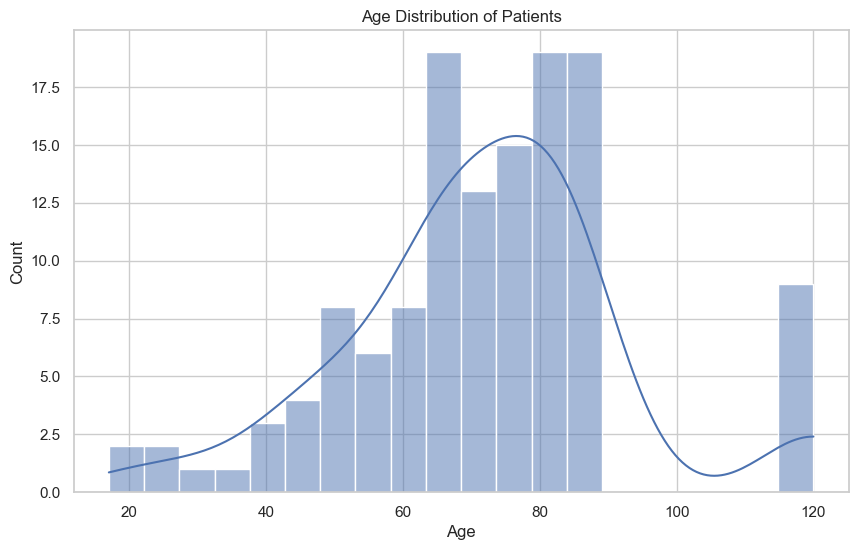

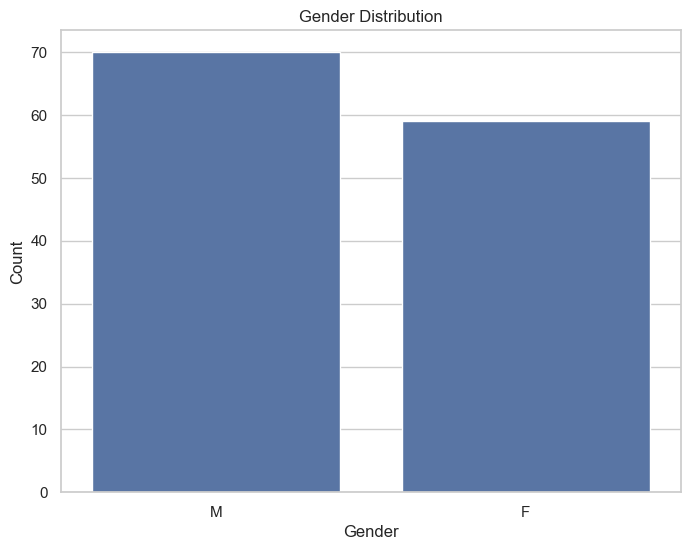

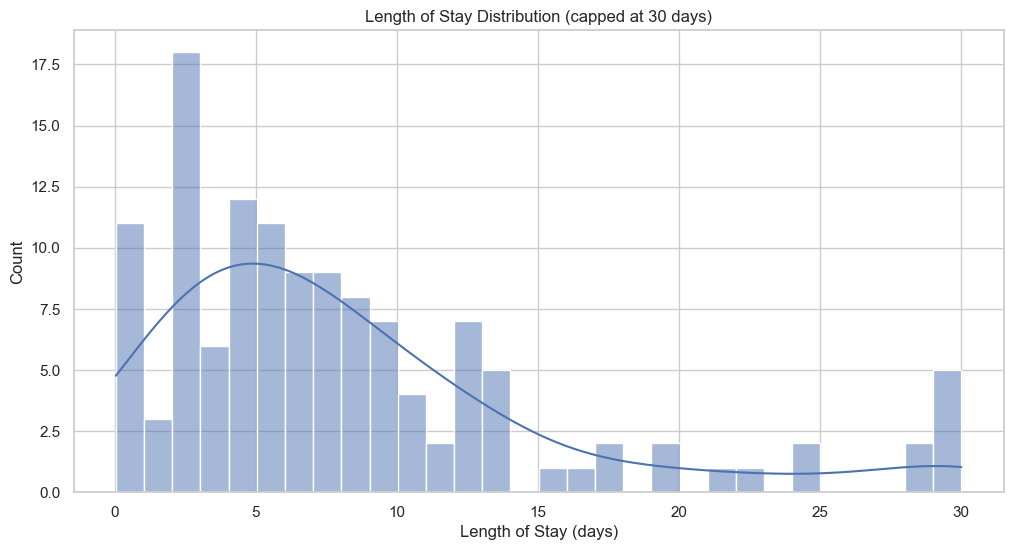

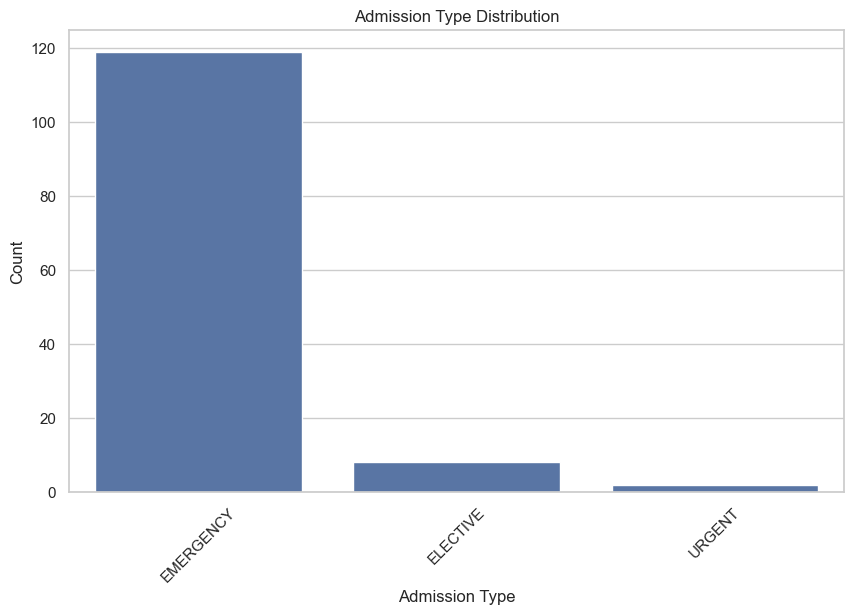

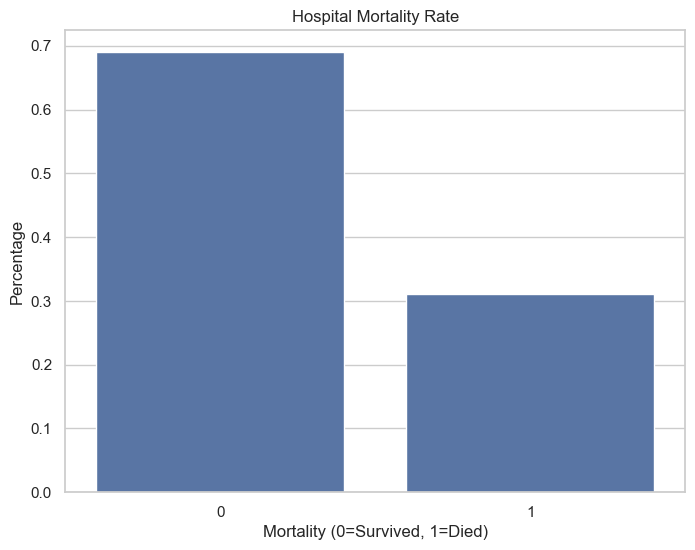

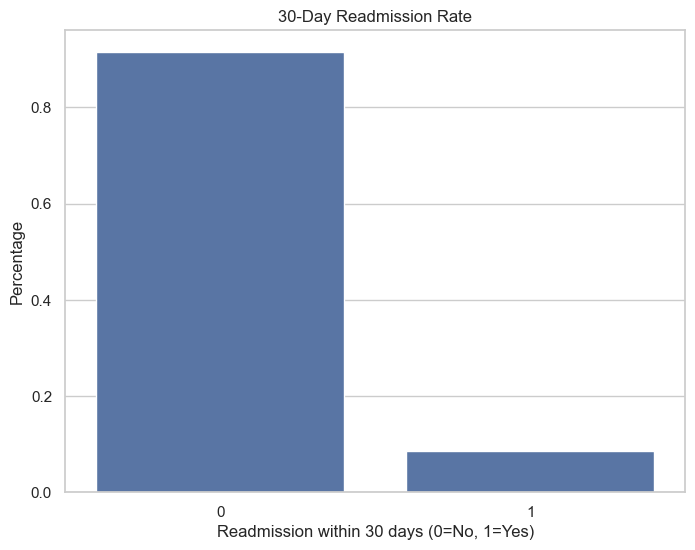

In [19]:
# Robust EDA plotting using case-insensitive lookups
# This cell replaces direct indexing with safe helpers to avoid KeyError when columns are missing.

def safe_hist(df, col_name, title, xlabel, bins=20, cap=None, figsize=(10,6)):
    col = find_col(df, col_name)
    if not col:
        print(f"Skipping '{title}': column '{col_name}' not found")
        return
    data = df[col].dropna()
    if data.empty:
        print(f"Skipping '{title}': column '{col_name}' exists but has no non-null values")
        return
    if cap is not None:
        data = data.clip(0, cap)
    plt.figure(figsize=figsize)
    sns.histplot(data, bins=bins, kde=True)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Count')
    plt.show()


def safe_bar_counts(df, col_name, title, xlabel, rotate=0, normalize=False, figsize=(8,6)):
    col = find_col(df, col_name)
    if not col:
        print(f"Skipping '{title}': column '{col_name}' not found")
        return
    counts = df[col].value_counts(normalize=normalize)
    if counts.empty:
        print(f"Skipping '{title}': column '{col_name}' has no values")
        return
    plt.figure(figsize=figsize)
    sns.barplot(x=counts.index, y=counts.values)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Percentage' if normalize else 'Count')
    if rotate:
        plt.xticks(rotation=rotate)
    plt.show()


# Now produce the EDA plots using the safe wrappers
safe_hist(patient_admissions, 'AGE', 'Age Distribution of Patients', 'Age', bins=20)

safe_bar_counts(patient_admissions, 'GENDER', 'Gender Distribution', 'Gender')

safe_hist(patient_admissions, 'LOS_DAYS', 'Length of Stay Distribution (capped at 30 days)', 'Length of Stay (days)', bins=30, cap=30, figsize=(12,6))

safe_bar_counts(patient_admissions, 'ADMISSION_TYPE', 'Admission Type Distribution', 'Admission Type', rotate=45, figsize=(10,6))

safe_bar_counts(patient_admissions, 'HOSPITAL_MORTALITY', 'Hospital Mortality Rate', 'Mortality (0=Survived, 1=Died)', normalize=True)

safe_bar_counts(patient_admissions, 'READMISSION_30D', '30-Day Readmission Rate', 'Readmission within 30 days (0=No, 1=Yes)', normalize=True)


## 6. Preparing Data for Modeling

Let's prepare the data for our modeling tasks.

In [21]:
# Robust feature selection and encoding (case-insensitive)
# Build a list of desired feature names and pick only those present in patient_admissions
desired_features = [
    'SUBJECT_ID', 'HADM_ID', 'AGE', 'GENDER', 'ADMISSION_TYPE',
    'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'INSURANCE',
    'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY',
    'LOS_DAYS', 'NUM_DIAGNOSES', 'NUM_PROCEDURES',
    'HOSPITAL_MORTALITY', 'READMISSION_30D'
]

# Use case-insensitive lookup to map desired features to actual column names present
present_cols = []
missing_cols = []
for f in desired_features:
    c = find_col(patient_admissions, f)
    if c:
        present_cols.append(c)
    else:
        missing_cols.append(f)

if missing_cols:
    print(f"Warning: the following desired features are missing from patient_admissions and will be skipped: {missing_cols}")

model_data = patient_admissions[present_cols].copy()

# Fill some common missing categorical defaults if those columns exist
for col, fill_val in [('LANGUAGE','UNKNOWN'), ('RELIGION','UNKNOWN'), ('MARITAL_STATUS','UNKNOWN')]:
    c = find_col(model_data, col)
    if c:
        model_data[c] = model_data[c].fillna(fill_val)

# Determine which categorical columns are present and safe to encode
categorical_candidates = ['GENDER', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
                          'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE',
                          'RELIGION', 'MARITAL_STATUS', 'ETHNICITY']
cols_to_encode = [find_col(model_data, c) for c in categorical_candidates if find_col(model_data, c)]

if cols_to_encode:
    print(f"Encoding categorical columns: {cols_to_encode}")
    model_data_encoded = pd.get_dummies(model_data, columns=cols_to_encode, drop_first=True)
else:
    print("No categorical columns found to encode; returning numeric-only model_data")
    model_data_encoded = model_data.copy()

print(f"Final model_data_encoded shape: {model_data_encoded.shape}")


Encoding categorical columns: ['gender', 'admission_type', 'admission_location', 'discharge_location', 'insurance', 'language', 'religion', 'marital_status', 'ethnicity']
Final model_data_encoded shape: (129, 56)


## 7. Save Processed Data

Let's save the processed data for use in our modeling notebooks.

In [22]:
# Create directory if it doesn't exist
os.makedirs('../src/data/processed', exist_ok=True)

# Save processed data
model_data_encoded.to_csv('../src/data/processed/mimic3_processed.csv', index=False)

# Save key tables for reference
patients.to_csv('../src/data/processed/mimic3_patients.csv', index=False)
admissions.to_csv('../src/data/processed/mimic3_admissions.csv', index=False)
diagnoses.to_csv('../src/data/processed/mimic3_diagnoses.csv', index=False)
procedures.to_csv('../src/data/processed/mimic3_procedures.csv', index=False)

print("Processed data saved successfully!")

Processed data saved successfully!


## 8. Next Steps

Now that we have preprocessed the MIMIC-III dataset, we can use this data for various modeling tasks:

1. **Classification Models**: Predict hospital mortality or 30-day readmission
2. **Regression Models**: Predict length of stay
3. **Clustering Models**: Identify patient subgroups with similar characteristics
4. **Association Rule Mining**: Discover relationships between diagnoses and procedures
5. **Time Series Analysis**: Analyze patient vital signs over time

These models will be implemented in separate notebooks.